In [1]:
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, make_scorer
from imblearn.metrics import specificity_score

from imblearn.pipeline import Pipeline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

In [2]:
protien = pd.read_csv("../sequences_training.txt", header=None)
protien.columns = ["protien_seq", "class"]
protien.head()

,protien_seq,class
0,MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...,nonDRNA
1,MEQKKMKYLENLVGKTPMLELIFDYKGEERRIFVKNESYNLTGSIK...,nonDRNA
2,MTILFQLALAALVILSFVMVIGVPVAYASPQDWDRSKQLIFLGSGL...,nonDRNA
3,MSKIERISAFLNDKEVDMTFITNPTTLNYLTGLAIDPHERIAGLMI...,nonDRNA
4,MSDQQQPPVYKIALGIEYDGSKYYGWQRQNEVRSVQEKLEKALSQV...,RNA


In [3]:
import sys

sys.path.append('../')

from FeatureExtraction import extract_features, clean_data

In [4]:
clean_protiens = clean_data(protien)
bio_features = extract_features(clean_protiens)
bio_features.head()

,class,protien_len,mol_weighht,isoelectric_point,Helix,Turn,Sheet,type1,type2,type3,...,N,P,Q,R,S,T,V,W,Y,pos_neg_rat
0,nonDRNA,155,17596.7878,-0.630968,0.341935,0.238710,0.329032,73,37,19,...,4.516129,3.225806,5.161290,6.451613,2.580645,6.451613,5.806452,3.870968,3.225806,1.368420
1,nonDRNA,336,37260.7955,-0.201190,0.366071,0.303571,0.366071,168,75,43,...,5.952381,3.273810,1.190476,2.976190,6.845238,4.166667,6.547619,0.297619,3.571429,1.162790
2,nonDRNA,62,6764.1710,1.579032,0.322581,0.209677,0.580645,48,10,2,...,1.612903,3.225806,4.838710,1.612903,6.451613,1.612903,17.741935,3.225806,1.612903,0.999995
3,nonDRNA,362,39968.9808,-0.141713,0.334254,0.281768,0.356354,187,74,57,...,4.419890,4.143646,2.209945,3.314917,4.696133,5.524862,6.906077,0.276243,2.486188,0.771930
4,RNA,270,30399.2510,-0.314074,0.300000,0.248148,0.355556,138,62,28,...,4.074074,5.555556,4.444444,7.407407,3.703704,5.185185,9.629630,1.851852,4.444444,1.499999


In [5]:
# most basic model I can work with, the standard scaler is here because SGD is sensitive to feature scaling
sgd_baseline = Pipeline([
    ('preprocessor', StandardScaler()),
    ('classifier', SGDClassifier(random_state=42))
])

X = bio_features.drop(columns=['class'])
y = bio_features['class']

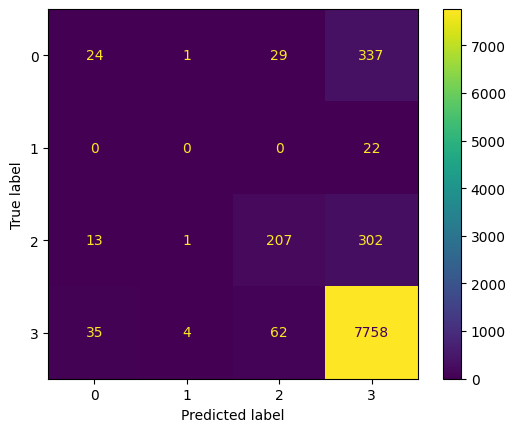

In [6]:
y_pred = cross_val_predict(sgd_baseline, X, y, cv=5)

cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [7]:
def prec_nonDRNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["nonDRNA"], average=None, zero_division=0)

def prec_DNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["DNA"], average=None, zero_division=0)

def prec_RNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["RNA"], average=None, zero_division=0)

def prec_DRNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["DRNA"], average=None, zero_division=0)

def rec_nonDRNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["nonDRNA"], average=None, zero_division=0)

def rec_DNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["DNA"], average=None, zero_division=0)

def rec_RNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["RNA"], average=None, zero_division=0)

def rec_DRNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["DRNA"], average=None, zero_division=0)

def spe_nonDRNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['nonDRNA'])[0]

def spe_DNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['DNA'])[0]

def spe_RNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['RNA'])[0]

def spe_DRNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['DRNA'])[0]

def specificity_micro(y_true, y_pred):
    return specificity_score(y_true, y_pred, average='micro')



In [8]:
scoring = {
        'precision_nonDRNA': make_scorer(prec_nonDRNA),
        'precision_DNA':     make_scorer(prec_DNA),
        'precision_RNA':     make_scorer(prec_RNA),
        'precision_DRNA':    make_scorer(prec_DRNA),
        'specificity_nonDRNA':    make_scorer(spe_nonDRNA),
        'specificity_DNA':        make_scorer(spe_DNA),
        'specificity_RNA':        make_scorer(spe_RNA),
        'specificity_DRNA':       make_scorer(spe_DRNA),
        'recall_nonDRNA':    make_scorer(rec_nonDRNA),
        'recall_DNA':        make_scorer(rec_DNA),
        'recall_RNA':        make_scorer(rec_RNA),
        'recall_DRNA':       make_scorer(rec_DRNA),
}

results = pd.DataFrame(cross_validate(sgd_baseline, X, y=y, scoring=scoring))
results = results.drop(columns=['fit_time','score_time'])
results = results.mean()
results

test_precision_nonDRNA      0.921523
test_precision_DNA          0.396591
test_precision_RNA          0.713436
test_precision_DRNA         0.000000
test_specificity_nonDRNA    0.293867
test_specificity_DNA        0.994288
test_specificity_RNA        0.988998
test_specificity_DRNA       0.999316
test_recall_nonDRNA         0.987149
test_recall_DNA             0.061311
test_recall_RNA             0.395751
test_recall_DRNA            0.000000
dtype: float64

In [9]:
for label in ['nonDRNA', 'DNA', 'RNA', 'DRNA']:
    print(f'{label}: {specificity_score(y, y_pred, average=None, labels=[label])[0]}')

nonDRNA: 0.2938034188034188
DNA: 0.99428843407901
RNA: 0.9889990328820116
DRNA: 0.9993160834378206


SGD is not an ml model, but an optimization algorithm used in many other ml algorithms. For this notebook, I will be using the losses hinge (linear SVM), modified_huber and log_loss (logistic regression) as different models to create.

# Hinge

## Test Preprocessors and Resamplers

In [10]:
params = {"sampler": [RandomOverSampler(random_state=42), ADASYN(random_state=42), SMOTE(random_state=42), TomekLinks(), RandomUnderSampler(random_state=42)],
         'preprocessor': [StandardScaler(), MinMaxScaler(), QuantileTransformer()]}

sgd_hinge = Pipeline([
    ('sampler', 'passthrough'),
    ('preprocessor', StandardScaler()),
    ('classifier', SGDClassifier(loss='hinge', random_state=42))
])

gs = GridSearchCV(sgd_hinge, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)


In [11]:
gs.fit(X, y)

/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (68). n_quantiles is set to n_samples.
 

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'preprocessor': [StandardScaler(), MinMaxScaler(), ...], 'sampler': [RandomOverSam...ndom_state=42), ADASYN(random_state=42), ...]}"
,scoring,"{'precision_DNA': make_scorer(p...hod='predict'), 'precision_DRNA': make_scorer(p...hod='predict'), 'precision_RNA': make_scorer(p...hod='predict'), 'precision_nonDRNA': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [12]:
results = pd.DataFrame(gs.cv_results_)

In [13]:
#cols = [x for x in list(results.columns) if 'mean' in x]
#cols += 
remove_cols = [x for x in list(results.columns) if 'split' in x] + ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']

In [14]:
results.drop(columns=remove_cols)

,param_preprocessor,param_sampler,mean_test_precision_nonDRNA,std_test_precision_nonDRNA,rank_test_precision_nonDRNA,mean_test_precision_DNA,std_test_precision_DNA,rank_test_precision_DNA,mean_test_precision_RNA,std_test_precision_RNA,...,rank_test_recall_nonDRNA,mean_test_recall_DNA,std_test_recall_DNA,rank_test_recall_DNA,mean_test_recall_RNA,std_test_recall_RNA,rank_test_recall_RNA,mean_test_recall_DRNA,std_test_recall_DRNA,rank_test_recall_DRNA
0,StandardScaler(),RandomOverSampler(random_state=42),0.971555,0.005601,7,0.159539,0.016268,7,0.334470,0.064039,...,10,0.437293,0.047045,7,0.606264,0.064715,3,0.45,0.118322,8
1,StandardScaler(),ADASYN(random_state=42),0.971172,0.005517,8,0.168672,0.013074,5,0.343666,0.027036,...,6,0.450179,0.019846,5,0.558535,0.084267,10,0.49,0.180000,6
2,StandardScaler(),SMOTE(random_state=42),0.972772,0.005006,4,0.162861,0.004486,6,0.321838,0.039586,...,8,0.452613,0.046890,3,0.579341,0.045312,7,0.46,0.048990,7
3,StandardScaler(),TomekLinks(),0.918780,0.004446,13,0.155556,0.193729,9,0.717462,0.048926,...,3,0.012821,0.019861,13,0.384322,0.062568,13,0.00,0.000000,13
4,StandardScaler(),RandomUnderSampler(random_state=42),0.952144,0.008045,12,0.087348,0.024205,12,0.152227,0.056719,...,14,0.357676,0.118346,11,0.460842,0.078910,11,0.57,0.244131,3
5,MinMaxScaler(),RandomOverSampler(random_state=42),0.972559,0.005802,5,0.185126,0.018843,1,0.347382,0.032380,...,5,0.452613,0.040899,3,0.625275,0.055132,1,0.54,0.048990,5
6,MinMaxScaler(),ADASYN(random_state=42),0.973709,0.003919,2,0.177318,0.010061,4,0.355392,0.045426,...,9,0.434599,0.069309,8,0.602326,0.054850,4,0.55,0.118322,4
7,MinMaxScaler(),SMOTE(random_state=42),0.971607,0.005199,6,0.182891,0.016348,2,0.370831,0.041004,...,7,0.450114,0.025793,6,0.588956,0.025514,6,0.59,0.091652,1
8,MinMaxScaler(),TomekLinks(),0.912733,0.003127,15,0.000000,0.000000,14,0.749286,0.056563,...,1,0.000000,0.000000,14,0.305806,0.047184,15,0.00,0.000000,13
9,MinMaxScaler(),RandomUnderSampler(random_state=42),0.961465,0.007753,10,0.087127,0.028387,13,0.158957,0.055922,...,15,0.321941,0.150637,12,0.566154,0.088734,8,0.59,0.091652,1


In [15]:
results[[x for x in list(results.columns) if 'rank' in x]].sum(axis=1)

0      89
1      87
2      79
3     102
4     138
5      55
6      66
7      66
8     104
9     122
10     95
11     89
12    101
13    104
14    128
dtype: int64

In [16]:
results[[x for x in list(results.columns) if 'mean' in x]].iloc[5]

mean_fit_time                    0.521258
mean_score_time                  0.051571
mean_test_precision_nonDRNA      0.972559
mean_test_precision_DNA          0.185126
mean_test_precision_RNA          0.347382
mean_test_precision_DRNA         0.011548
mean_test_specificity_nonDRNA    0.828046
mean_test_specificity_DNA        0.905163
mean_test_specificity_RNA        0.924925
mean_test_specificity_DRNA       0.882478
mean_test_recall_nonDRNA         0.721342
mean_test_recall_DNA             0.452613
mean_test_recall_RNA             0.625275
mean_test_recall_DRNA            0.540000
Name: 5, dtype: float64

In [17]:
results['params'][5]

{'preprocessor': MinMaxScaler(), 'sampler': RandomOverSampler(random_state=42)}

## Preprocessing Results
- Tomek links and random under sampler are the worst performing resampling techiques
- min max scalar is the best performing preprocessor
- The best overall parameters:
  - MinMaxScaler(), RandomOverSampler(random_state=42)

## Test Model Parameters

In [26]:
params = {
    'classifier__l1_ratio': [0.0, 0.15, 0.25, 0.5, 0.75, 1.0],
    'classifier__class_weight': [None, {'nonDRNA': 0.25, 'DNA': 0.5, 'RNA': 0.5, 'DRNA':1}, {'nonDRNA': 0.5, 'DNA': 1, 'RNA': 1, 'DRNA':1}],
    'classifier__alpha': [0.001, 0.0001, 0.00001]
}

sgd_hinge2 = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', MinMaxScaler()),
    ('classifier', SGDClassifier(loss='hinge', random_state=42, penalty='elasticnet', n_jobs=-1))
])

gs2 = GridSearchCV(sgd_hinge2, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)

In [27]:
gs2.fit(X, y)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__alpha': [0.001, 0.0001, ...], 'classifier__class_weight': [None, {'DNA': 0.5, 'DRNA': 1, 'RNA': 0.5, 'nonDRNA': 0.25}, ...], 'classifier__l1_ratio': [0.0, 0.15, ...]}"
,scoring,"{'precision_DNA': make_scorer(p...hod='predict'), 'precision_DRNA': make_scorer(p...hod='predict'), 'precision_RNA': make_scorer(p...hod='predict'), 'precision_nonDRNA': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [28]:
results2 = pd.DataFrame(gs2.cv_results_)

In [37]:
results2[[x for x in list(results2.columns) if 'rank' in x]].sum(axis=1).sort_values().head(10)

19    227
18    229
20    229
21    239
5     253
22    253
31    268
23    268
30    268
32    270
dtype: int64

In [40]:
[x for x in list(results2.columns) if 'rank' in x]

['rank_test_precision_nonDRNA',
 'rank_test_precision_DNA',
 'rank_test_precision_RNA',
 'rank_test_precision_DRNA',
 'rank_test_specificity_nonDRNA',
 'rank_test_specificity_DNA',
 'rank_test_specificity_RNA',
 'rank_test_specificity_DRNA',
 'rank_test_recall_nonDRNA',
 'rank_test_recall_DNA',
 'rank_test_recall_RNA',
 'rank_test_recall_DRNA']

In [39]:
results2[[x for x in list(results2.columns) if 'mean' in x]].iloc[19]

mean_fit_time                    0.475144
mean_score_time                  0.092383
mean_test_precision_nonDRNA      0.972609
mean_test_precision_DNA          0.198065
mean_test_precision_RNA          0.325632
mean_test_precision_DRNA         0.011272
mean_test_specificity_nonDRNA    0.828058
mean_test_specificity_DNA        0.917539
mean_test_specificity_RNA        0.915496
mean_test_specificity_DRNA       0.879970
mean_test_recall_nonDRNA         0.722234
mean_test_recall_DNA             0.424570
mean_test_recall_RNA             0.640531
mean_test_recall_DRNA            0.540000
Name: 19, dtype: float64

In [38]:
results2['params'].iloc[19]

{'classifier__alpha': 0.0001,
 'classifier__class_weight': None,
 'classifier__l1_ratio': 0.15}

Just looking at the best overall scores, not much has changes from my inital tests. Lets look at each of the 3 scores individually

In [43]:
results2[[x for x in list(results2.columns) if 'rank_test_precision' in x]].sum(axis=1).sort_values().head(5)

20    67
18    70
19    72
22    74
21    77
dtype: int64

In [44]:
results2[[x for x in list(results2.columns) if 'rank_test_specificity' in x]].sum(axis=1).sort_values().head(5)

22    72
18    73
19    75
20    77
23    79
dtype: int64

In [45]:
results2[[x for x in list(results2.columns) if 'rank_test_recall' in x]].sum(axis=1).sort_values().head(5)

34    69
31    72
33    73
30    74
32    77
dtype: int64

In [46]:
# 18 is number 2 for precision and specificity
results2[[x for x in list(results2.columns) if 'mean' in x]].iloc[18]

mean_fit_time                    0.573775
mean_score_time                  0.082593
mean_test_precision_nonDRNA      0.972559
mean_test_precision_DNA          0.185126
mean_test_precision_RNA          0.347382
mean_test_precision_DRNA         0.011548
mean_test_specificity_nonDRNA    0.828046
mean_test_specificity_DNA        0.905163
mean_test_specificity_RNA        0.924925
mean_test_specificity_DRNA       0.882478
mean_test_recall_nonDRNA         0.721342
mean_test_recall_DNA             0.452613
mean_test_recall_RNA             0.625275
mean_test_recall_DRNA            0.540000
Name: 18, dtype: float64

In [47]:
# 34 has the best overall recall
results2[[x for x in list(results2.columns) if 'mean' in x]].iloc[34]

mean_fit_time                    0.458476
mean_score_time                  0.098651
mean_test_precision_nonDRNA      0.979867
mean_test_precision_DNA          0.155480
mean_test_precision_RNA          0.278725
mean_test_precision_DRNA         0.010646
mean_test_specificity_nonDRNA    0.887894
mean_test_specificity_DNA        0.871487
mean_test_specificity_RNA        0.891682
mean_test_specificity_DRNA       0.873017
mean_test_recall_nonDRNA         0.643218
mean_test_recall_DNA             0.485849
mean_test_recall_RNA             0.655879
mean_test_recall_DRNA            0.540000
Name: 34, dtype: float64

In [48]:
results2['params'].iloc[18]

{'classifier__alpha': 0.0001,
 'classifier__class_weight': None,
 'classifier__l1_ratio': 0.0}

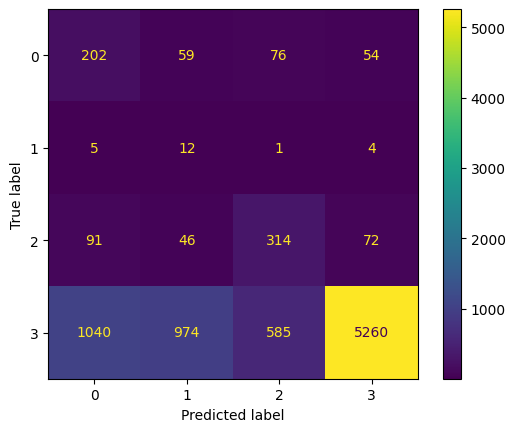

In [77]:
# confusion matrix for number 19 (it is equivalant to default parameters, lol
y_pred = cross_val_predict(sgd_hinge2, X, y, cv=5)

cm2 = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm2).plot()

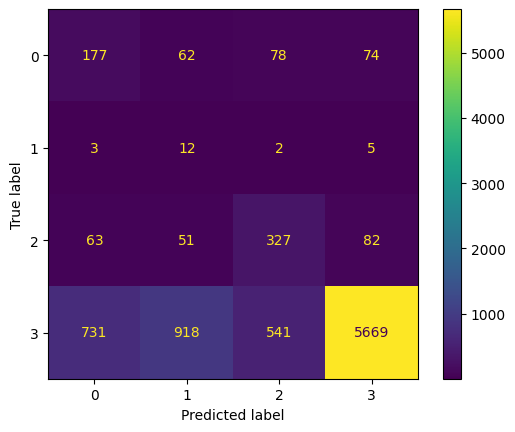

In [51]:
# confusion matrix for number 18
sgd_hinge3 = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', MinMaxScaler()),
    ('classifier', SGDClassifier(loss='hinge', random_state=42, penalty='l2', n_jobs=-1))
])


y_pred = cross_val_predict(sgd_hinge3, X, y, cv=5)

cm2 = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm2).plot()

For the hinge loss function (linear SVM), I will use the parameters for # 19

```
Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', MinMaxScaler()),
    ('classifier', SGDClassifier(loss='hinge', random_state=42, penalty='elasticnet', n_jobs=-1))
])
```

# Log Loss

## Test Preprocessing and Sampling

In [52]:
sgd_baseline = Pipeline([
    ('preprocessor', StandardScaler()),
    ('classifier', SGDClassifier(random_state=42, loss='log_loss'))
])

X = bio_features.drop(columns=['class'])
y = bio_features['class']

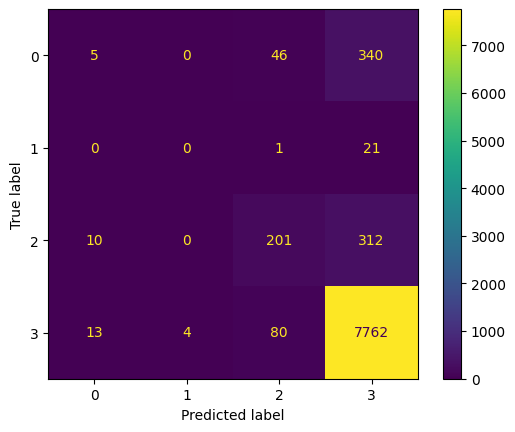

In [76]:
y_pred = cross_val_predict(sgd_baseline, X, y, cv=5)

cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [54]:
params = {"sampler": [RandomOverSampler(random_state=42), ADASYN(random_state=42), SMOTE(random_state=42), TomekLinks(), RandomUnderSampler(random_state=42)],
         'preprocessor': [StandardScaler(), MinMaxScaler(), QuantileTransformer()]}

sgd_ll = Pipeline([
    ('sampler', 'passthrough'),
    ('preprocessor', StandardScaler()),
    ('classifier', SGDClassifier(loss='log_loss', random_state=42))
])

gs3 = GridSearchCV(sgd_hinge, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)

In [55]:
gs3.fit(X, y)

/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
/Users/connorfair/CMSC_436_Projects/GroupProject2/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (68). n_quantiles is set to n_samples.
 

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'preprocessor': [StandardScaler(), MinMaxScaler(), ...], 'sampler': [RandomOverSam...ndom_state=42), ADASYN(random_state=42), ...]}"
,scoring,"{'precision_DNA': make_scorer(p...hod='predict'), 'precision_DRNA': make_scorer(p...hod='predict'), 'precision_RNA': make_scorer(p...hod='predict'), 'precision_nonDRNA': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [57]:
results_ll = pd.DataFrame(gs3.cv_results_)

In [58]:
results_ll[[x for x in list(results_ll.columns) if 'rank' in x]].sum(axis=1).sort_values()

5      53
7      63
6      64
2      80
1      86
0      90
10     90
11     97
3     103
8     104
13    104
12    106
9     122
14    128
4     137
dtype: int64

In [60]:
results_ll[[x for x in list(results_ll.columns) if 'mean' in x]].iloc[5]

mean_fit_time                    0.448541
mean_score_time                  0.059395
mean_test_precision_nonDRNA      0.972559
mean_test_precision_DNA          0.185126
mean_test_precision_RNA          0.347382
mean_test_precision_DRNA         0.011548
mean_test_specificity_nonDRNA    0.828046
mean_test_specificity_DNA        0.905163
mean_test_specificity_RNA        0.924925
mean_test_specificity_DRNA       0.882478
mean_test_recall_nonDRNA         0.721342
mean_test_recall_DNA             0.452613
mean_test_recall_RNA             0.625275
mean_test_recall_DRNA            0.540000
Name: 5, dtype: float64

In [61]:
results_ll['params'].iloc[5]

{'preprocessor': MinMaxScaler(), 'sampler': RandomOverSampler(random_state=42)}

## Test Model Parameters

In [63]:
params = {
    'classifier__l1_ratio': [0.0, 0.15, 0.25, 0.5, 0.75, 1.0],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__alpha': [0.001, 0.0001, 0.00001]
}

sgd_hinge2 = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', MinMaxScaler()),
    ('classifier', SGDClassifier(loss='log_loss', random_state=42, penalty='elasticnet', n_jobs=-1))
])

gs3 = GridSearchCV(sgd_hinge2, params, scoring=scoring,refit=False , cv=5, n_jobs=-1)

In [64]:
gs3.fit(X, y)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__alpha': [0.001, 0.0001, ...], 'classifier__class_weight': [None, 'balanced'], 'classifier__l1_ratio': [0.0, 0.15, ...]}"
,scoring,"{'precision_DNA': make_scorer(p...hod='predict'), 'precision_DRNA': make_scorer(p...hod='predict'), 'precision_RNA': make_scorer(p...hod='predict'), 'precision_nonDRNA': make_scorer(p...hod='predict'), ...}"
,n_jobs,-1
,refit,False
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [65]:
results_ll = pd.DataFrame(gs3.cv_results_)

In [73]:
results_ll[[x for x in list(results_ll.columns) if 'rank' in x]].sum(axis=1).sort_values().head(10)

11    152
10    152
4     152
5     152
9     184
29    184
35    184
3     184
26    194
32    194
dtype: int64

In [71]:
results_ll[[x for x in list(results_ll.columns) if 'mean' in x]].iloc[11]

mean_fit_time                    0.216837
mean_score_time                  0.122006
mean_test_precision_nonDRNA      0.974444
mean_test_precision_DNA          0.158893
mean_test_precision_RNA          0.357433
mean_test_precision_DRNA         0.011120
mean_test_specificity_nonDRNA    0.845125
mean_test_specificity_DNA        0.881009
mean_test_specificity_RNA        0.931091
mean_test_specificity_DRNA       0.879628
mean_test_recall_nonDRNA         0.700854
mean_test_recall_DNA             0.480688
mean_test_recall_RNA             0.604212
mean_test_recall_DRNA            0.530000
Name: 11, dtype: float64

In [72]:
results_ll['params'].iloc[11]

{'classifier__alpha': 0.001,
 'classifier__class_weight': 'balanced',
 'classifier__l1_ratio': 1.0}

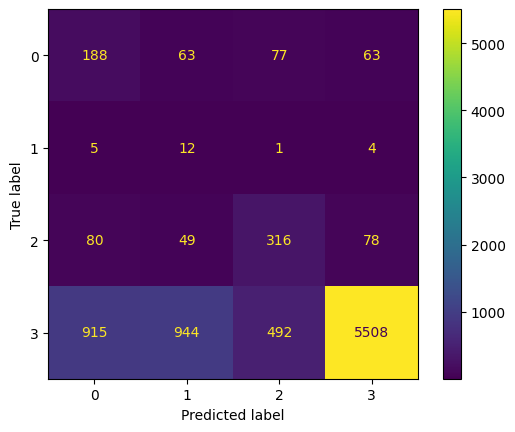

In [74]:
sgd_ll = Pipeline([
    ('sampler', RandomOverSampler(random_state=42)),
    ('preprocessor', MinMaxScaler()),
    ('classifier', SGDClassifier(loss='log_loss', random_state=42, penalty='l1', n_jobs=-1, alpha=0.001, class_weight='balanced'))
])

y_pred = cross_val_predict(sgd_ll, X, y, cv=5)

cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()